# Trendlines

In [ ]:
!pip install ax-platform
!pip install mplfinance
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
import numpy
# from mpl_finance import candlestick_ohlc
import yfinance as yf
import pandas as pd
from google.colab import files
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
from matplotlib import pyplot
from io import StringIO
import requests
from sklearn.cluster import KMeans
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.4/596.4 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
uploaded = files.upload()

Saving PTBA.csv to PTBA.csv


In [ ]:
df = pd.read_csv('PTBA.csv')
df.columns = map(str.lower, df.columns)
# df = df[columns]
df = df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.head(10)

,date,open,high,low,close,volume,dividends,stock splits
0,2002-12-23,38.850140,38.850140,37.231384,38.850140,74795000,0.0,0.0
1,2002-12-27,38.850140,38.850140,37.231384,38.850140,36812500,0.0,0.0
2,2003-01-02,38.850132,38.850132,35.612621,37.231377,149657500,0.0,0.0
3,2003-01-03,37.231377,37.231377,35.612621,37.231377,16197500,0.0,0.0
4,2003-01-06,35.612625,37.231381,33.993870,33.993870,119477500,0.0,0.0
5,2003-01-07,35.612617,35.612617,33.993862,35.612617,17337500,0.0,0.0
6,2003-01-08,33.993862,35.612617,33.993862,35.612617,2952500,0.0,0.0
7,2003-01-09,35.612625,35.612625,33.993870,33.993870,1625000,0.0,0.0
8,2003-01-10,33.993862,35.612617,33.993862,35.612617,212500,0.0,0.0
9,2003-01-13,35.612617,35.612617,33.993862,35.612617,6285000,0.0,0.0


# K Means

In [ ]:
start = "2020-01-01"
end = "2023-12-31"

df.date = pd.DatetimeIndex(df.date)
df = df.set_index(df.date)
df = df.drop(['date'], axis=1)
df_filter = df.loc[(df.index >= start)
                     & (df.index < end)]
print(df_filter.shape)
df_filter.head()

(790, 7)


,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2020-01-02,1888.796500,1917.414629,1860.178371,1881.641968,8093400,0.0,0.0
2020-01-03,1867.332938,1910.260132,1860.178406,1910.260132,13483900,0.0,0.0
2020-01-06,1895.951236,1960.342033,1881.642170,1953.187500,26770600,0.0,0.0
2020-01-07,1953.187238,1960.341770,1888.796450,1938.878174,22952100,0.0,0.0
2020-01-08,1931.723729,1931.723729,1888.796535,1910.260132,15608000,0.0,0.0


In [ ]:
df_train = df_filter[:int(len(df_filter) * 0.9)]
df_test = df_filter[len(df_train):]


print(df_train.shape)
print(df_test.shape)

(711, 7)
(79, 7)


In [ ]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

Optimum K is 10
Optimum K is 10
[[1345.1680136 ]
 [1676.43007434]
 [1921.4186818 ]
 [2186.64026701]
 [2368.05129116]
 [2823.06264465]
 [3152.74389559]
 [3684.34797957]
 [4003.53061262]
 [4235.55555556]]
[[1423.29528533]
 [1726.99841442]
 [1981.80691517]
 [2260.91382422]
 [2441.36969472]
 [2894.39509361]
 [3198.15177964]
 [3679.42780179]
 [3968.2728339 ]
 [4293.06451613]]


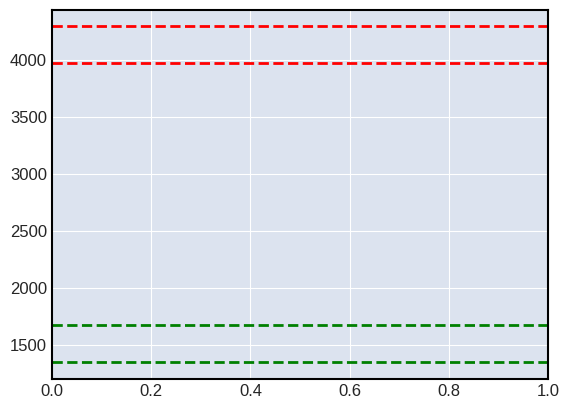

In [ ]:
data = df_train
lows = pd.DataFrame(data=data, index=data.index, columns=["low"])
highs = pd.DataFrame(data=data, index=data.index, columns=["high"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

# print(data)
print(low_centers)
print(high_centers)

for low in low_centers[:2]:
    plt.axhline(low[0], color='green', ls='--')

for high in high_centers[-2:]:
    plt.axhline(high[0], color='red', ls='--')

In [ ]:
low = 99999999
high = -9999999
for low_c in low_centers:
    if low_c[0] > df_test['close'].min() and low_c[0] < low:
      low = low_c[0]

for high_c in high_centers:
    if high_c[0] < df_test['close'].max() and high_c[0] > high:
      high = high_c[0]

In [ ]:
print(df_test['close'].min())
print(df_test['close'].max())
print(low)
print(high)

3260.0
4010.0
3684.347979566421
3968.2728339039268


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


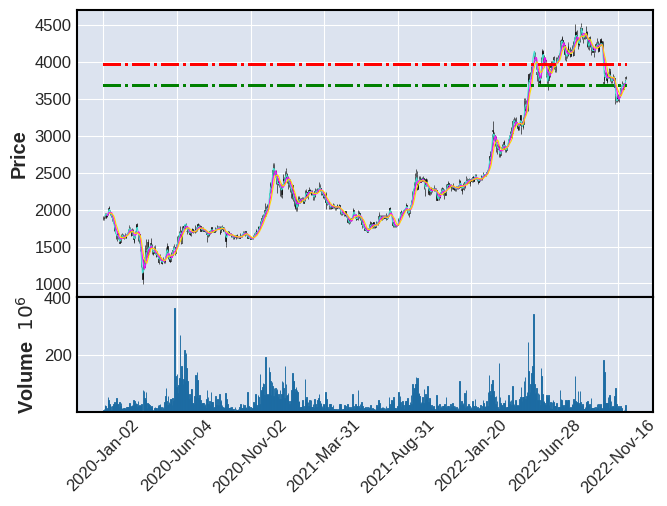

In [ ]:
mpf.plot(df_train,type='candle',mav=(3,6,9),volume=True, hlines=dict(hlines=[low,high],colors=['g','r'],linestyle='-.'))

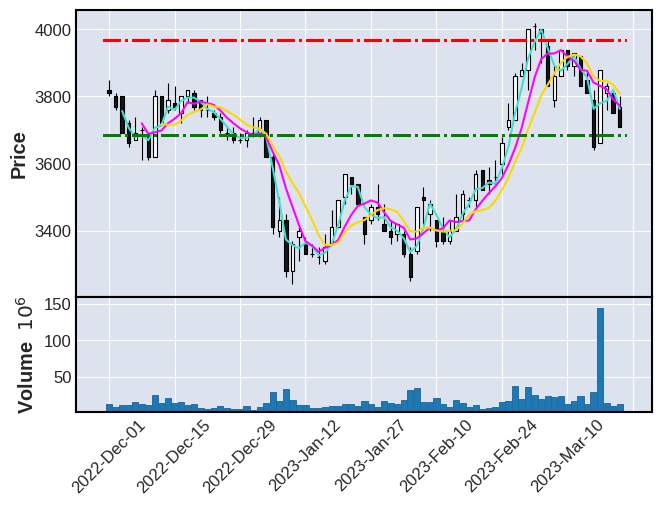

In [ ]:
mpf.plot(df_test,type='candle',mav=(3,6,9),volume=True, hlines=dict(hlines=[low,high],colors=['g','r'],linestyle='-.'))

In [ ]:
# Ekstrak Signal Tahan, Jual, Beli

#If the price on that day crosses the resistance line then it will experience an increase, then signal SELL (1)
#If the price on that day does not cross the support line then it will experience an increase, then signal SELL (2)
#If the price on that day crosses the support line then it will experience a decrease, then signal BUY (3)
#if it doesn't cross the resistance line it will experience a decrise, then signal BUY (4)
from collections import Counter
current_price = df_test['close'] # asumsi harga saham realtime
signals = []
for i in range(len(current_price)):
    # Reset a flag to check if i meet any condition
    signal = 'HOLD'

    if i > 0 and current_price[i] > high and current_price[i-1] < high and current_price[i-1] < current_price[i]: # Condition (1)
      signal = 'SELL'

    if i > 0 and current_price[i] < low and current_price[i-1] > low and current_price[i-1] > current_price[i]: # Condition (3)
      signal = 'BUY'

    if i > 0 and low <= current_price[i] <= high:
      low_i = current_price[i] - low
      high_i = current_price[i] - high
      # print(low_i)
      # print(high_i)
      if abs(low_i) <= (high - low)/4 or abs(high_i) >= (high - low)/2:

        if abs(low_i) < abs(high_i) and current_price[i-1] < current_price[i]: # Condition (2)
          signal = 'SELL'

        if abs(high_i) <= abs(low_i) and current_price[i-1] > current_price[i]: # Condition (4)
          signal = 'BUY'

    signals.append(signal)

print(signals)
print(len(signals))
print(Counter(signals))

['HOLD', 'HOLD', 'HOLD', 'BUY', 'SELL', 'SELL', 'BUY', 'SELL', 'HOLD', 'SELL', 'HOLD', 'SELL', 'SELL', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'HOLD', 'SELL', 'HOLD', 'SELL', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'HOLD', 'HOLD', 'SELL', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD']
79
Counter({'HOLD': 64, 'SELL': 10, 'BUY': 5})


In [ ]:
# Simulasi Pembelian Saham

import math

cash = 10000000
lot = 0
lots = []
close = df_test['close']
open = df_test['open']
current_open = 0

for i in range(len(signals)):
  if lot == 0 and signals[i] == 'BUY':
    lot = math.floor(cash / (open[i] * 100))
    cash = cash - (lot * open[i] * 100)
    current_open = open[i]
    lots.append(lot)

  if lot > 0 and signals[i] == 'SELL' and close[i] > current_open:
    cash = cash + (lot * close[i] * 100)
    lot = 0
    current_open = 0

  if i == (len(signals) - 1):
    cash = cash + (lot * current_open * 100)

print(lots)
print(cash)


[26, 27, 27, 29]
11045000.0


In [ ]:
# dfpl = df[4500:4700]
# fig = go.Figure(data = [go.Candlestick(x=dfpl.index,
#                                        open = dfpl['open'],
#                                        high = dfpl['high'],
#                                        low = dfpl['low'],
#                                        close = dfpl['close'])])
# fig.show()

In [ ]:
# backcandles = 100
# wind = 5
# candleid = 4500

# maxim = np.array([])
# minim = np.array([])
# minid = np.array([])
# maxid = np.array([])

# for i in range(candleid - backcandles, candleid + 1, wind):
#   minim = np.append(minim, df.low.iloc[i:i+wind].min())
#   minid = np.append(minid, df.low.iloc[i:i+wind].idxmin())
# for i in range(candleid - backcandles, candleid + 1, wind):
#   maxim = np.append(maxim, df.low.iloc[i:i+wind].max())
#   maxid = np.append(maxid, df.low.iloc[i:i+wind].idxmax())

# slmin, intercmin = np.polyfit(minid, minim, 1)
# slmax, intercmax = np.polyfit(maxid, maxim, 1)

# dfpl = df[candleid-backcandles:candleid+backcandles]
# fig = go.Figure(data = [go.Candlestick(x=dfpl.index,
#                                        open = dfpl['open'],
#                                        high = dfpl['high'],
#                                        low = dfpl['low'],
#                                        close = dfpl['close'])])
# adjintercmin = (df.low.iloc[minid] - slmin*minid).min()
# adjintercmax = (df.high.iloc[maxid] - slmax*maxid).max()
# fig.add_trace(go.Scatter(x=minid, y=slmin*minid+adjintercmin, mode='lines', name='minimum slope'))
# fig.add_trace(go.Scatter(x=maxid, y=slmax*maxid+adjintercmax, mode='lines', name='maximum slope'))

In [ ]:
# backcandles = 177 #6 * 30
# brange = 40 #backcandles//5
# wind = 5
# candleid = 4500

# optbackcandles = backcandles
# sldiff = 100
# sldist = 1000

# for r1 in range(backcandles-brange, backcandles+brange):
#   maxim = np.array([])
#   minim = np.array([])
#   minid = np.array([])
#   maxid = np.array([])

#   for i in range(candleid - r1, candleid + 1, wind):
#     minim = np.append(minim, df.low.iloc[i:i+wind].min())
#     minid = np.append(minid, df.low.iloc[i:i+wind].idxmin())
#   for i in range(candleid - r1, candleid + 1, wind):
#     maxim = np.append(maxim, df.low.iloc[i:i+wind].max())
#     maxid = np.append(maxid, df.low.iloc[i:i+wind].idxmax())
#   slmin, intercmin = np.polyfit(minid, minim, 1)
#   slmax, intercmax = np.polyfit(maxid, maxim, 1)

#   dist = (slmax*candleid+intercmax)-(slmin*candleid+intercmin)
#   if(dist<sldist):
#     # sldiff = abs(slmin-slmax)
#     optbackcandles = r1
#     sldist = dist
#     slmaxopt = slmax
#     slminopt = slmin
#     intercminopt = intercmin
#     intercmaxopt = intercmax
#     maximopt = maxim.copy()
#     minimopt = minim.copy()
#     maxidopt = maxid.copy()
#     minidopt = minid.copy()

# print(optbackcandles)
# dfpl = df[candleid-wind-optbackcandles-backcandles:candleid+optbackcandles]
# fig = go.Figure(data = [go.Candlestick(x=dfpl.index,
#                                        open = dfpl['open'],
#                                        high = dfpl['high'],
#                                        low = dfpl['low'],
#                                        close = dfpl['close'])])
# adjintercmin = (df.low.iloc[minidopt] - slminopt*minidopt).min()
# adjintercmax = (df.high.iloc[maxidopt] - slmaxopt*maxidopt).max()
# fig.add_trace(go.Scatter(x=minidopt, y=slminopt*minidopt+adjintercmin, mode='lines', name='minimum slope'))
# fig.add_trace(go.Scatter(x=maxidopt, y=slmaxopt*maxidopt+adjintercmax, mode='lines', name='maximum slope'))

177


In [ ]:
# backcandles = 100
# wind = 5
# candleid = 4890

# maxim = np.array([])
# minim = np.array([])
# minid = np.array([])
# maxid = np.array([])

# for i in range(candleid - backcandles, candleid + 1, wind):
#   minim = np.append(minim, df.low.iloc[i:i+wind].min())
#   minid = np.append(minid, df.low.iloc[i:i+wind].idxmin())
# for i in range(candleid - backcandles, candleid + 1, wind):
#   maxim = np.append(maxim, df.low.iloc[i:i+wind].max())
#   maxid = np.append(maxid, df.low.iloc[i:i+wind].idxmax())

# slmin, intercmin = np.polyfit(minid, minim, 1)
# slmax, intercmax = np.polyfit(maxid, maxim, 1)

# dfpl = df[candleid-backcandles:candleid+backcandles]
# fig = go.Figure(data = [go.Candlestick(x=dfpl.index,
#                                        open = dfpl['open'],
#                                        high = dfpl['high'],
#                                        low = dfpl['low'],
#                                        close = dfpl['close'])])
# fig.add_trace(go.Scatter(x=minid, y=slmin*minid+intercmin, mode='lines', name='minimum slope'))
# fig.add_trace(go.Scatter(x=maxid, y=slmax*maxid+intercmax, mode='lines', name='maximum slope'))

In [ ]:
# adjintercmin = df.low.loc[candleid-backcandles:candleid].min() - slmin*df.low.iloc[candleid-backcandles:candleid].idxmin()
# adjintercmax = df.high.loc[candleid-backcandles:candleid].max() - slmax*df.high.iloc[candleid-backcandles:candleid].idxmax()

# fig.add_trace(go.Scatter(x=minid, y=slmin*minid+adjintercmin, mode='lines', name='minimum slope'))
# fig.add_trace(go.Scatter(x=maxid, y=slmax*maxid+adjintercmax, mode='lines', name='maximum slope'))
# fig.show()

In [ ]:
# def plot_stock_data(data):
#     fig, ax = plt.subplots()
#     ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
#     ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

#     ax1.set_title("{} - {}".format("PTBA", start))
#     ax1.set_facecolor("#131722")

#     candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')
#     fig.subplots_adjust(hspace=0)
#     return ax1

# def mydate(x,pos):
#     try:
#         return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
#     except IndexError:
#         return ''

In [ ]:
# print(low_centers[2][0])
# print("\n")
# print(high_centers[-2][0])
# print("\n")
# current_price = data['close']
# class_0 = [] #undefined class
# class_1 = [] #If the price on that day crosses the resistance line then it will experience an increase
# class_2 = [] #If the price on that day does not cross the support line then it will experience an increase
# class_3 = [] #If the price on that day crosses the support line then it will experience a decrease
# class_4 = [] #if it doesn't cross the resistance line it will experience a decrise
# for i in current_price:
#     # Reset a flag to check if i meets any condition
#     meets_condition = False
#     low = low_centers[2][0]
#     high = high_centers[-2][0]
#     if i - high >= 30:
#       class_1.append(i)
#       meets_condition = True
#     elif 20 <= high - i <= 50:
#       class_4.append(i)
#       meets_condition = True
#     if 30 <= i - low <= 50:
#       class_2.append(i)
#       meets_condition = True
#     elif low - i >= 20:
#       class_3.append(i)
#       meets_condition = True
#     # If i doesn't meet any condition, append it to class_0
#     if not meets_condition:
#         class_0.append(i)
# for i in class_1:
#   print("class_1")
#   print(i)
# print("\n")
# for i in class_2:
#   print("class_2")
#   print(i)
# print("\n")
# for i in class_3:
#   print("class_3")
#   print(i)
# print("\n")
# for i in class_4:
#   print("class_4")
#   print(i)
# print("\n")
# for i in class_0:
#   print("class_0")
#   print(i)

3360.0


3932.5


class_1
4000.0
class_1
4010.0
class_1
3990.0


class_2
3400.0
class_2
3410.0
class_2
3390.0
class_2
3400.0
class_2
3400.0


class_3
3330.0
class_3
3330.0
class_3
3320.0
class_3
3330.0
class_3
3260.0


class_4
3890.0


class_0
3350.0
class_0
3490.0
class_0
3570.0
class_0
3540.0
class_0
3480.0
class_0
3470.0
class_0
3450.0
class_0
3380.0
class_0
3420.0
class_0
3470.0
class_0
3490.0
class_0
3480.0
class_0
3370.0
class_0
3370.0
class_0
3440.0
class_0
3510.0
class_0
3490.0
class_0
3570.0
class_0
3520.0
class_0
3540.0
class_0
3560.0
class_0
3660.0
class_0
3730.0
class_0
3860.0
class_0
3880.0
class_0
3830.0
class_0
3860.0
class_0
3940.0
class_0
3930.0
class_0
3830.0
class_0
3810.0
class_0
3650.0
class_0
3880.0
class_0
3830.0
class_0
3750.0
class_0
3710.0


ERROR:yfinance:CBIO: 1m data not available for startTime=1576731600 and endTime=1576818000. The requested range must be within the last 30 days.


Optimum K is 0


<ipython-input-44-cc985803a383>:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)


IndexError: ignored

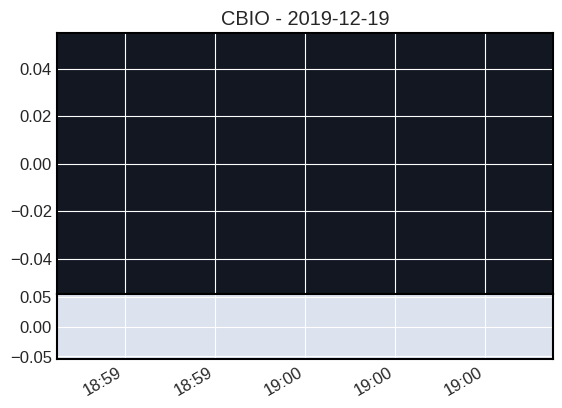

In [ ]:
# """
# https://www.github.com/judopro
# https://www.medium.com/@judopro
# """
# import datetime
# import pytz
# from sklearn.cluster import KMeans
# from matplotlib import pyplot as plt
# import matplotlib.ticker as mpticker
# import pandas
# import numpy

# from mpl_finance import candlestick_ohlc

# import yfinance as yf
# yf.pdr_override()


# def get_optimum_clusters(df, saturation_point=0.05):
#     '''

#     :param df: dataframe
#     :param saturation_point: The amount of difference we are willing to detect
#     :return: clusters with optimum K centers

#     This method uses elbow method to find the optimum number of K clusters
#     We initialize different K-means with 1..10 centers and compare the inertias
#     If the difference is no more than saturation_point, we choose that as K and move on
#     '''

#     wcss = []
#     k_models = []

#     size = min(11, len(df.index))
#     for i in range(1, size):
#         kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#         kmeans.fit(df)
#         wcss.append(kmeans.inertia_)
#         k_models.append(kmeans)

#     # Compare differences in inertias until it's no more than saturation_point
#     optimum_k = len(wcss)-1
#     for i in range(0, len(wcss)-1):
#         diff = abs(wcss[i+1] - wcss[i])
#         if diff < saturation_point:
#             optimum_k = i
#             break

#     print("Optimum K is " + str(optimum_k + 1))
#     optimum_clusters = k_models[optimum_k]

#     return optimum_clusters


# def plot_stock_data(data):
#     fig, ax = plt.subplots()
#     ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
#     ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

#     ax1.set_title("{} - {}".format(symbol, start))
#     ax1.set_facecolor("#131722")
#     ax1.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))

#     candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')

#     ax2.bar(data['Time'], data['Volume'], width=30)
#     ax2.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))
#     fig.subplots_adjust(hspace=0)
#     fig.autofmt_xdate()
#     return ax1


# def mydate(x,pos):
#     try:
#         return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
#     except IndexError:
#         return ''


# symbol = "CBIO"
# start = "2019-12-19"
# end = "2019-12-20"
# est = pytz.timezone('US/Eastern')
# date_format = "%H:%M"

# ticker = yf.Ticker(symbol)
# data = ticker.history(period="1d", interval="1m",start=start, end=end, prepost=False, actions=False)
# data = data[:60] #30 1M candles

# data["Time"] = [d.timestamp() for d in data.index]
# data.Time = data.Time.tz_convert(est)
# data = data[["Time", "Open", "High", "Low", "Close", "Volume"]]

# ax = plot_stock_data(data)

# lod, hod = 0, 0

# lows = pandas.DataFrame(data=data, index=data.index, columns=["Low"])
# highs = pandas.DataFrame(data=data, index=data.index, columns=["High"])

# low_clusters = get_optimum_clusters(lows)
# low_centers = low_clusters.cluster_centers_
# low_centers = numpy.sort(low_centers, axis=0)

# high_clusters = get_optimum_clusters(highs)
# high_centers = high_clusters.cluster_centers_
# high_centers = numpy.sort(high_centers, axis=0)

# print(data)
# print(low_centers)
# print(high_centers)

# for low in low_centers[:2]:
#     ax.axhline(low[0], color='yellow', ls='--')

# for high in high_centers[-1:]:
#     ax.axhline(high[0], color='orange', ls='--')

# plt.show()

In [ ]:
# def trading_decision(current_price, low_centers, high_centers):
#     if current_price < low_centers[0][0]:
#         return "Buy"
#     elif low_centers[0][0] <= current_price <= low_centers[1][0]:
#         return "Hold"
#     elif current_price > high_centers[1][0]:
#         return "Sell"
#     else:
#         return "Undecided"

# from sklearn.linear_model import LinearRegression

# # ... (existing code remains the same)

# # Convert the DataFrame data to numpy arrays
# X = np.array(data.index).reshape(-1, 1)
# y = np.array(data['low'])

# # Create and fit the Linear Regression model
# model = LinearRegression()
# model.fit(X, y)

# # Predict using the model
# predicted_price = model.predict(np.array([0])[0].reshape(-1, 1))[0]

# # Use the predicted price in the trading decision
# action = trading_decision(predicted_price, low_centers, high_centers)
# print(f"Predicted price: {predicted_price}")
# print(f"Recommendation: {action}")

Predicted price: 47700.75392350097
Recommendation: Sell


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# # Assuming 'data' is your historical dataset
# def predict_action(current_price, low_centers, high_centers):
#     if current_price < low_centers[0][0]:
#         return "Buy"
#     elif low_centers[0][0] <= current_price <= high_centers[-1][0]:
#         return "Hold"
#     else:
#         return "Sell"
# # Add a column for the trading recommendation based on the low and high centers
# data['Recommendation'] = data.apply(lambda row: predict_action(row['close'], low_centers, high_centers), axis=1)

# # Extract features and labels
# X = data[['low', 'high']].values
# y = data['Recommendation'].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train your model using X_train and y_train

# # Make predictions on the testing set
# y_pred = model.predict(X_test)

# # Calculate the F1 score
# f1 = f1_score(y_test, y_pred, average='weighted')
# print(f"F1 Score: {f1}")
# print(y_pred)

F1 Score: 1.0
['Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold']


<ipython-input-28-3bdd0d2213e4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

